In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/week-number/weeknummers2020.xlsx


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from pathlib import Path
import os
from scipy import signal


In [3]:
def SP_profile(days_hours,days,Night_T_SP,Day_T_SP):
    
    '''Create a Temperature SP profile
    
    days_hours : number_of_hour_in_oneday + start hour at 0
    days       : number of simulation days (365 days for a year)
    Night_T_SP : temperature SP at night
    Day_T_SP   : temperature SP in working hours.
    '''
    
    """Temperature different between day and night."""
    
    delta_T= Day_T_SP - Night_T_SP

    """Define Work time """
    Wo_time =7;           """Work time start at 7 in the morning """
    duty_wo = 23-7       

    """Go to home time/ leave the working place """
    home_time = 18;           """Go home at 18 in the afternoon """
    duty_ho   = 23-18        

    """Back to home """
    #back_home = 18;         """Back home at 18.00 """
    #duty_b   = 23-18 


    #-----------------------
    t= np.linspace(0,1,(days_hours*days)+1,endpoint=False)          #+1 start from 0 days=1
    temp1 = signal.square(2 * np.pi* days * t,duty=duty_wo/24)
    temp1 = np.clip(temp1, 0, 1)
    # add delay to array
    temp1=np.roll(temp1,Wo_time)

    #----------------
    t= np.linspace(0,1,(days_hours*days)+1,endpoint=False)          #+1 start from 0 days=1
    temp2 = signal.square(2 * np.pi* days * t,duty=duty_ho/24)
    temp2 = np.clip(temp2, 0, 1)
    # add delay to array
    temp2=np.roll(temp2,home_time)

    '''
    #___________
    t= np.linspace(0,1,(days_hours*days)+1,endpoint=False)          #+1 start from 0 days=1
    temp3 = signal.square(2 * np.pi* days * t,duty=duty_b/24)
    temp3 = np.clip(temp3, 0, 1)
    # add delay to array
    temp3=np.roll(temp3,back_home)
    '''

    # Calculate SP

    temp4=temp1-temp2#+temp3
    SP=(temp4*delta_T)+Night_T_SP

    SP=SP[np.newaxis]
    SP=SP.T
    SP=np.delete(SP, -1, 0)
    return SP

In [4]:
print(Path.cwd())
#print(os.listdir("../kaggle/input"))
parent_dir = os.chdir('/kaggle/')
data_dir = Path.cwd() /'input/week-number'
print(os.listdir("../kaggle/input/week-number/"))
#output_dir = Path.cwd()/'working'/'submit'
NENdata_path = data_dir/'weeknummers2020.xlsx'
xls = pd.ExcelFile(NENdata_path)    

/kaggle/working
['weeknummers2020.xlsx']


In [5]:
xls.sheet_names  # Check sheet names

['Pivot', 'DATA']

In [6]:
data = pd.read_excel(xls,'DATA')

In [7]:
print(data)

         Datum        Dag  Weeknummer     Maand Kwartaal      Waarde
0   2020-01-01   woensdag           1   januari      Q 1  100.000000
1   2020-01-02  donderdag           1   januari      Q 1  120.000000
2   2020-01-03    vrijdag           1   januari      Q 1  130.000000
3   2020-01-04   zaterdag           1   januari      Q 1   90.000000
4   2020-01-05     zondag           1   januari      Q 1   80.000000
..         ...        ...         ...       ...      ...         ...
361 2020-12-27     zondag          52  december      Q 4  229.202011
362 2020-12-28    maandag          53  december      Q 4  234.047786
363 2020-12-29    dinsdag          53  december      Q 4  238.876457
364 2020-12-30   woensdag          53  december      Q 4  243.705128
365 2020-12-31  donderdag          53  december      Q 4  248.533800

[366 rows x 6 columns]


In [8]:
'''
Input Netherlands national holidays
'''

holidays = ['2020-01-01','2020-04-10','2020-04-12',
            '2020-04-13','2020-04-27','2020-05-05','2020-05-21','2020-06-01',
            '2020-12-25','2020-12-26','2020-12-31']

In [10]:
'''
Get date, time column from data frame and convert to str
'''
time = data['Datum']
time= time.astype(str)
date = data['Dag']
date= date.astype(str)

In [11]:
print(time),print(date)

0      2020-01-01
1      2020-01-02
2      2020-01-03
3      2020-01-04
4      2020-01-05
          ...    
361    2020-12-27
362    2020-12-28
363    2020-12-29
364    2020-12-30
365    2020-12-31
Name: Datum, Length: 366, dtype: object
0       woensdag
1      donderdag
2        vrijdag
3       zaterdag
4         zondag
         ...    
361       zondag
362      maandag
363      dinsdag
364     woensdag
365    donderdag
Name: Dag, Length: 366, dtype: object


(None, None)

In [13]:
'''
Create SP profile base on weekday, weekend and holidays.
holidays and weekkend have the same profiel

'''
week_day = SP_profile(days_hours=24,days=1,Night_T_SP=15,Day_T_SP=20)
day_off  = SP_profile(days_hours=24,days=1,Night_T_SP=15,Day_T_SP=15)
temp2 = np.zeros((0,1))

for i in range(len(data)):
    #print('i',i)
    temp  = week_day
    #if data.iloc[i]['Dag'] == 'zaterdag' or data.iloc[i]['Dag'] == 'zondag':
    if date.iloc[i]=='zaterdag' or date.iloc[i] == 'zondag': 
        temp  = day_off
        #print('------------------weekend------------------')
    for x in range (len(holidays)):
        if time.iloc[i] == holidays[x]:
            temp  = day_off
            #temp2 = np.concatenate((temp2, temp))
            #print('-------------------holiday------------------')
    
    #print('--week day-----',i)
    #temp  = week_day
    temp2 = np.concatenate((temp2, temp))

In [15]:
print(len(temp2))

8784


0
100
102
103
117
125
141
152
359
360
365

8785


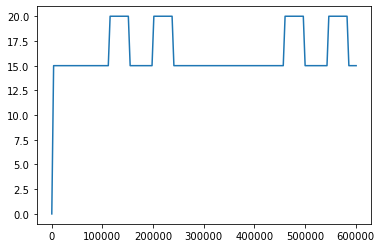

In [17]:
"""Define Temperature SP

    Assume that in normal working day, office building start at 7.00, 
    and close at 18.00. Weekend and holidays office building is closed
    
"""
days_hours   = 24                    #number_of_hour_in_oneday + start hour at 0
days         = 366                   #number of simulation days
periods      = 24*3600*days          #in seconds (day_periods*365 = years)

#create simulation time
time_t = np.linspace(0,periods,(days_hours*days)+1)
row_to_be_added = np.array([0]) 
# Adding row to numpy array 
result =temp2
#result=np.delete(temp2, np.s_[0:24], axis = 0)

#result=np.delete(result, np.s_[117*24:118*24], axis = 0)
result = np.vstack ((row_to_be_added,result))

print(len(result))
plt.plot(time_t[0*24:7*24],result[0*24:7*24])
#plt.plot(time_t,result)